# geopotential height

In [1]:
import xarray as xr
import numpy as np
import requests
import xclim as xc
import numpy as np
import xarray as xr
import geopandas
import pydap as pd
import pandas as pd
from visjobs.visualize import easy_plot
import os
from glob import glob
from cartopy.io.img_tiles import Stamen, StamenTerrain, QuadtreeTiles, GoogleWTS, OSM, MapQuestOpenAerial
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy
import proplot as plot
import matplotlib.patheffects as PathEffects
import matplotlib as mpl
import cartopy.crs as ccrs
from xclim.core.calendar import percentile_doy
from scipy.ndimage.filters import minimum_filter, maximum_filter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.io.shapereader import Reader
import cartopy.io.shapereader as shapereader
from cartopy.feature import ShapelyFeature
from pylab import rcParams

rcParams['figure.figsize'] = 21,24

In [2]:
pre_data_path = r'C:\Users\USER\Documents\Climaturk\Climatology_Of_Storms_Data'
years = ['1990', '1993', '1994', '2006', '2007', '2019']
m = 7
month = 'July'

In [3]:
def is_amj(month):
    m = 7
    return (month == m)

In [4]:
# tüm variablelar için quantileları hesapla
#ilkten sadece ilk 4 yıl verisi  alalım
# veri büyüklüğü nedeniyle işlemleri teker teker verilerle yapacaz

# 1990-1993
data = xr.open_dataset(pre_data_path + r'\z_{}_{}.nc'.format(years[0], years[1]))

lon = data['longitude']
lat = data['latitude']

data_jan_1990_1993 = data.sel(time=is_amj(data['time.month']))
data.close()

In [5]:
lon = data['longitude']
lat = data['latitude']

In [6]:
# tüm variablelar için quantileları hesapla
# veri büyüklüğü nedeniyle işlemleri teker teker verilerle yapacaz

# 1994-2006
data = xr.open_dataset(pre_data_path + r'\z_{}_{}.nc'.format(years[2], years[3]))

data_jan_1994_2006 = data.sel(time=is_amj(data['time.month']))

data.close()

In [7]:
### tüm variablelar için quantileları hesapla
# veri büyüklüğü nedeniyle işlemleri teker teker verilerle yapacaz

# 2007-2019
data = xr.open_dataset(pre_data_path + r'\z_{}_{}.nc'.format(years[4], years[5]))

data_jan_2007_2019 = data.sel(time=is_amj(data['time.month']))

data.close()

In [8]:
data_january = xr.concat([data_jan_1990_1993,
                          data_jan_1994_2006,
                          data_jan_2007_2019], dim='time')

In [9]:
#hourly to daily min
t2min_daily = data_january.resample(time='1D', keep_attrs=True).min(dim='time')

#max
t2max_daily = data_january.resample(time='1D', keep_attrs=True).max(dim='time')

In [10]:
# 0.1 quantile for min
jan_quantile_10_min = t2min_daily.quantile(0.1, dim='time')
jan_quantile_50_min = t2min_daily.quantile(0.5, dim='time')
jan_quantile_90_min = t2min_daily.quantile(0.9, dim='time')

In [11]:
# 0.1 quantile for max
jan_quantile_10_max = t2max_daily.quantile(0.1, dim='time')
jan_quantile_50_max = t2max_daily.quantile(0.5, dim='time')
jan_quantile_90_max = t2max_daily.quantile(0.9, dim='time')
ds_height = [jan_quantile_10_min, jan_quantile_50_min, jan_quantile_90_min,
             jan_quantile_10_max, jan_quantile_50_max, jan_quantile_90_max]

In [12]:
%%capture
# görsel
var = '500height'
short_title_max = '500 mb Daily Maximum Geopotential Height'
short_title_min = '500 mb Daily Minimum Geopotential Height'

pctls = [10, 50, 90, 10, 50, 90]
#draw map
m = easy_plot.painter()
tiler = Stamen('watercolor')
count=0
for i in range(len(ds_height)):
    if i < 3:
        short_title = short_title_min
        saved_method = 'min'
        
    else:
        short_title = short_title_max
        saved_method = 'max'

    count+=1
    work_title = '{} | {} Percentile'.format(month, pctls[i])
        #paint features
    ax = m.paint_ax(1,1,1, check_proj=True)

    #featureler
    ax.add_feature(cartopy.feature.LAND.with_scale('10m'),  zorder=1, linewidths=1.5, edgecolor='none', facecolor='white')
    m.paint_borders(ax=ax, res='10m', zorder=4, linewidths=1.5, edgecolor='red' )
    m.paint_lakes(ax=ax, res='10m', zorder=2, linewidths=1.5, edgecolor='red', facecolor='none' )
    m.paint_states(ax=ax, res='10m', zorder=4, linewidths=0.4, edgecolor='red',  )
    m.paint_coastline(ax=ax, res='10m', zorder=3, linewidths=1.8, edgecolor='red')
    fc = ax.set_facecolor('black')

    ax.set_extent([25, 45, 33, 45])
    
    interval = np.arange(np.min(ds_height[i]['z'])/10, np.max(ds_height[i]['z'])/10, 3)
    #make the freezing rain reflectivities contourf
    mesh_2 = ax.contour(lon, lat, ds_height[i]['z']/10, interval, transform=cartopy.crs.PlateCarree(), zorder=6, alpha=0.9,
                        colors='k' )
    m.plot_clabel(mesh_2, fontsize=25, inline=1, inline_spacing=7,fmt='%i', rightside_up=True, use_clabeltext=True , ax=ax, zorder=5)
    
    #colorbar
    #cb_ticks = np.array([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150])
    #cbaxes = inset_axes(ax, width="70%", height="3%", loc=3) 
    #cb = plt.colorbar(mesh_2, cax=cbaxes, orientation='horizontal')
    #cbaxes.xaxis.set_ticks_position('top')
    #cb.ax.tick_params(labelsize=14, labelcolor='white', color='white' )
    #----
    
    
    valid_era = m.set_title(title='ERA-5 Reanalysis', right = 0.850, up=0.010, ax=ax, fontsize=16,
                                 style='italic', color='white', zorder=20, transform=ax.transAxes, weight='bold'
                                 )
    
    valid_t = m.set_title(title='1990-2019 Baseline', right = 0.850, up=1.010, ax=ax, fontsize=16,
                                 style='italic', color='red', zorder=20, transform=ax.transAxes, weight='bold'
                                 )

    #titles
    title_short = m.set_title(title='{}'.format(short_title), ax=ax, fontsize=20, up=1.030, 
                             weight='heavy',style='italic',transform=ax.transAxes)
    
    title1 = m.set_title(title='{}'.format(work_title), ax=ax, fontsize=16, up=1.010, 
                             weight='heavy',style='italic',transform=ax.transAxes)
    title2 = m.set_title(title='Climaturk.com', color='white', right=0.00730, up=0.9615000, ax=ax, size=25, 
                                 zorder=53,style='italic',transform=ax.transAxes, weight='bold',
                                    )
    title2.set_path_effects([PathEffects.withStroke(linewidth=6, foreground='k')])
    
    #savefig path
    path1 = r'C:\Users\USER\JupyterLab\Climaturk_Site\Codes\Monthly_Quantiles\Quantile_Pictures'
    try:
        os.chdir(path1)
        os.mkdir(month)
    except:
        print('Directory exists')

    path2 = r'C:\Users\USER\JupyterLab\Climaturk_Site\Codes\Monthly_Quantiles\Quantile_Pictures\{}'.format(month)
    try:
        os.chdir(path2)
        os.mkdir(var)
    except:
        print('Directory exists')

    path3 = r'C:\Users\USER\JupyterLab\Climaturk_Site\Codes\Monthly_Quantiles\Quantile_Pictures\{}\{}'.format(month, var)
    try:
        os.chdir(path3)
        os.mkdir(saved_method)
    except:
        print('Directory exists')

    
    #save figure
    plt.savefig(path3 + '\{}'.format(saved_method) + '\\' + '{}.jpeg'.format(pctls[i]),
                  bbox_inches='tight', optimize=True, progressive=True, dpi=50)
    print('{}. map is done'.format(count))
    

# 2m temperature

In [4]:
# tüm variablelar için quantileları hesapla
#ilkten sadece ilk 4 yıl verisi  alalım
# veri büyüklüğü nedeniyle işlemleri teker teker verilerle yapacaz

# 1990-1993
data = xr.open_dataset(pre_data_path + r'\t2m_{}_{}.nc'.format(years[0], years[1]))

lon = data['longitude']
lat = data['latitude']

data_jan_1990_1993 = data.sel(time=is_amj(data['time.month']))

data.close()

In [5]:
# tüm variablelar için quantileları hesapla
# veri büyüklüğü nedeniyle işlemleri teker teker verilerle yapacaz

# 1994-2006
data = xr.open_dataset(pre_data_path + r'\t2m_{}_{}.nc'.format(years[2], years[3]))

data_jan_1994_2006 = data.sel(time=is_amj(data['time.month']))

data.close()

In [6]:
# tüm variablelar için quantileları hesapla
# veri büyüklüğü nedeniyle işlemleri teker teker verilerle yapacaz

# 2007-2019
data = xr.open_dataset(pre_data_path + r'\t2m_{}_{}.nc'.format(years[4], years[5]))

data_jan_2007_2019 = data.sel(time=is_amj(data['time.month']))

data.close()

In [7]:
lon = data['longitude']
lat = data['latitude']

In [8]:
data_january = xr.concat([data_jan_1990_1993,
                          data_jan_1994_2006,
                          data_jan_2007_2019], dim='time')

In [9]:
#hourly to daily min
t2min_daily = data_january.resample(time='1D', keep_attrs=True).min(dim='time')

#max
t2max_daily = data_january.resample(time='1D', keep_attrs=True).max(dim='time')

In [18]:
# 0.1 quantile for min
jan_quantile_10_min = t2min_daily.quantile(0.1, dim='time')
jan_quantile_50_min = t2min_daily.quantile(0.5, dim='time')
jan_quantile_90_min = t2min_daily.quantile(0.9, dim='time')

In [13]:
# 0.1 quantile for max
jan_quantile_10_max = t2max_daily.quantile(0.1, dim='time')
jan_quantile_50_max = t2max_daily.quantile(0.5, dim='time')
jan_quantile_90_max = t2max_daily.quantile(0.9, dim='time')
ds_height = [jan_quantile_10_min, jan_quantile_50_min, jan_quantile_90_min,
             jan_quantile_10_max, jan_quantile_50_max, jan_quantile_90_max]

NameError: name 'jan_quantile_10_min' is not defined

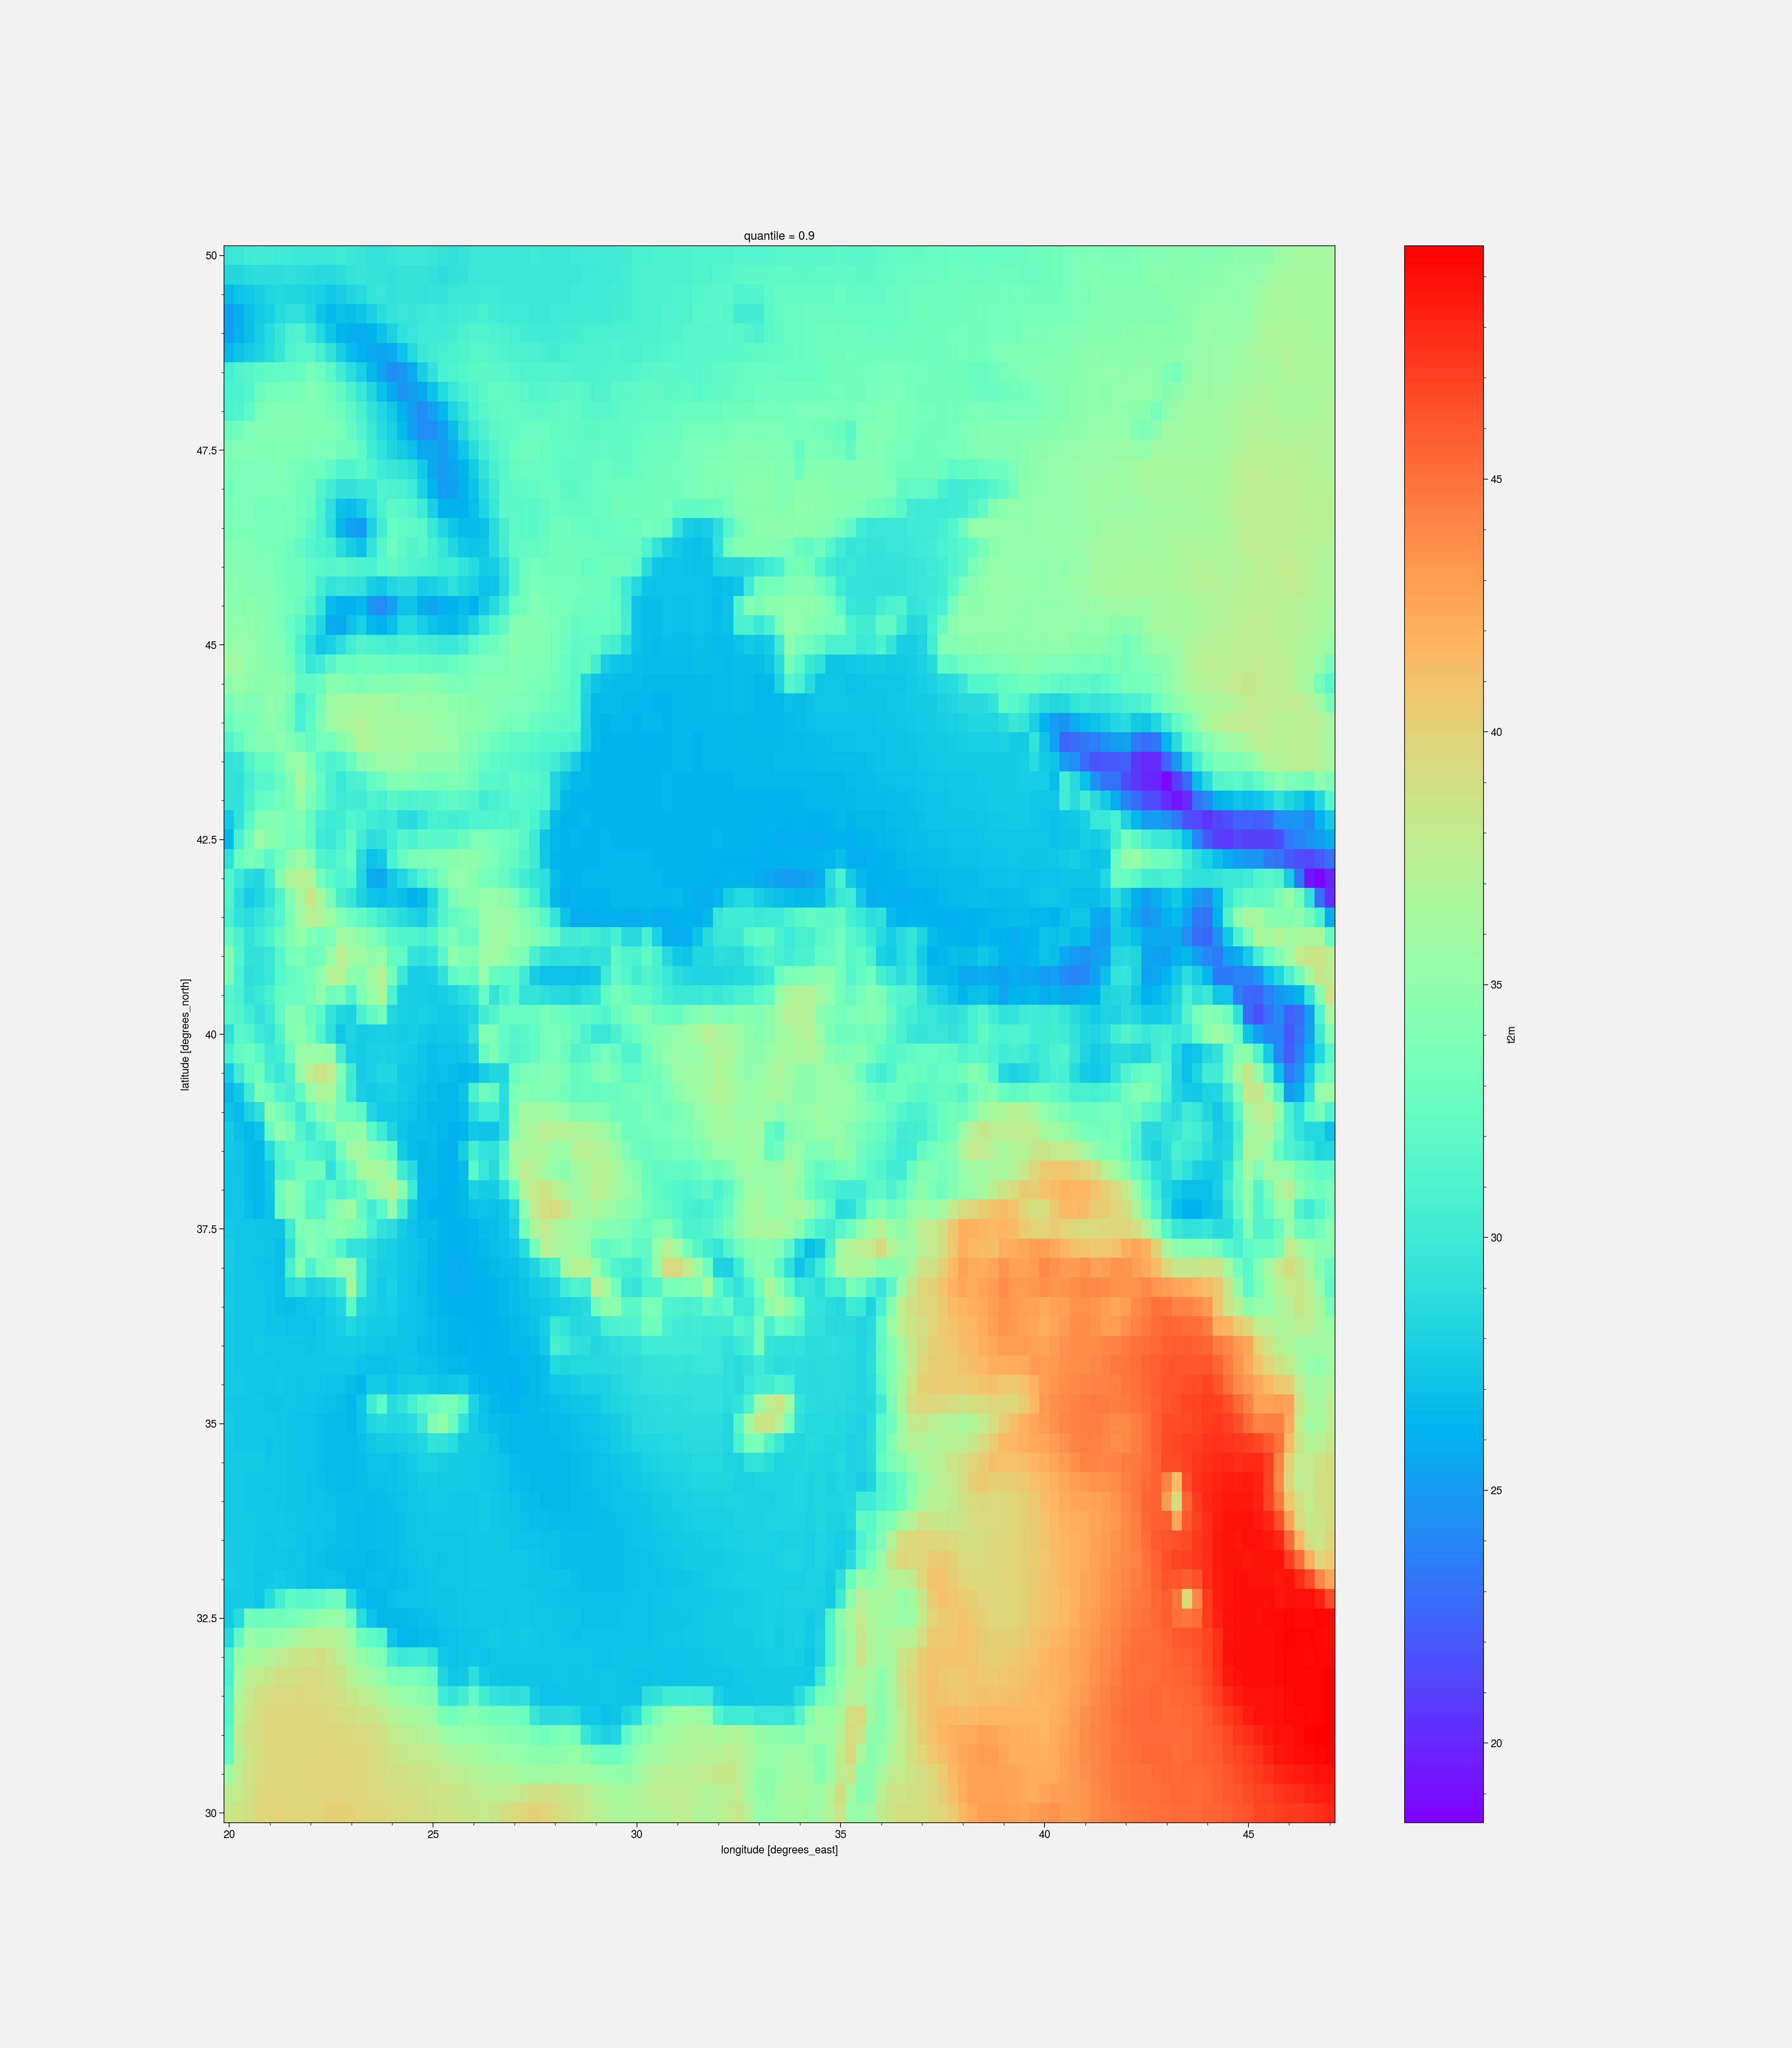

In [20]:
(jan_quantile_90_max['t2m']-273.15).plot(cmap='rainbow')

In [20]:
%%capture
# görsel
var = '2mtemp'
short_title_max = '2 meters Maximum Daily Temperature'
short_title_min = '2 meters Minimum Daily Temperature'

pctls = [10, 50, 90, 10, 50, 90]
#draw map
m = easy_plot.painter()
tiler = Stamen('watercolor')
count=0
for i in range(len(ds_height)):
    if i < 3:
        short_title = short_title_min
        saved_method = 'min'
        
    else:
        short_title = short_title_max
        saved_method = 'max'

    count+=1
    work_title = '{} | {} Percentile'.format(month, pctls[i])
        #paint features
    ax = m.paint_ax(1,1,1, check_proj=True)

    #featureler
    ax.add_feature(cartopy.feature.LAND.with_scale('10m'),  zorder=1, linewidths=1.5, edgecolor='none', facecolor='white')
    m.paint_borders(ax=ax, res='10m', zorder=4, linewidths=1.5, edgecolor='red' )
    m.paint_lakes(ax=ax, res='10m', zorder=2, linewidths=1.5, edgecolor='red', facecolor='none' )
    m.paint_states(ax=ax, res='10m', zorder=4, linewidths=0.4, edgecolor='red',  )
    m.paint_coastline(ax=ax, res='10m', zorder=3, linewidths=1.8, edgecolor='red')
    fc = ax.set_facecolor('black')

    ax.set_extent([25, 45, 33, 45])
    
    interval = np.arange(np.min(ds_height[i]['t2m'])-273.15, np.max(ds_height[i]['t2m'])-273.15, 2)
    #make the freezing rain reflectivities contourf
    mesh_2 = ax.contour(lon, lat, ds_height[i]['t2m']-273.15, interval, transform=cartopy.crs.PlateCarree(), zorder=6, alpha=0.9,
                        colors='k' )
    m.plot_clabel(mesh_2, fontsize=25, inline=1, inline_spacing=7,fmt='%i', rightside_up=True, use_clabeltext=True , ax=ax, zorder=5)
    
    #colorbar
    #cb_ticks = np.array([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150])
    #cbaxes = inset_axes(ax, width="70%", height="3%", loc=3) 
    #cb = plt.colorbar(mesh_2, cax=cbaxes, orientation='horizontal')
    #cbaxes.xaxis.set_ticks_position('top')
    #cb.ax.tick_params(labelsize=14, labelcolor='white', color='white' )
    #----
    
    
    valid_era = m.set_title(title='ERA-5 Reanalysis', right = 0.850, up=0.010, ax=ax, fontsize=16,
                                 style='italic', color='white', zorder=20, transform=ax.transAxes, weight='bold'
                                 )
    
    valid_t = m.set_title(title='1990-2019 Baseline', right = 0.850, up=1.010, ax=ax, fontsize=16,
                                 style='italic', color='red', zorder=20, transform=ax.transAxes, weight='bold'
                                 )

    #titles
    title_short = m.set_title(title='{}'.format(short_title), ax=ax, fontsize=20, up=1.030, 
                             weight='heavy',style='italic',transform=ax.transAxes)
    
    title1 = m.set_title(title='{}'.format(work_title), ax=ax, fontsize=16, up=1.010, 
                             weight='heavy',style='italic',transform=ax.transAxes)
    title2 = m.set_title(title='Climaturk.com', color='white', right=0.00730, up=0.9615000, ax=ax, size=25, 
                                 zorder=53,style='italic',transform=ax.transAxes, weight='bold',
                                    )
    title2.set_path_effects([PathEffects.withStroke(linewidth=6, foreground='k')])
    
    #savefig path
    path1 = r'C:\Users\USER\JupyterLab\Climaturk_Site\Codes\Monthly_Quantiles\Quantile_Pictures'
    try:
        os.chdir(path1)
        os.mkdir(month)
    except:
        print('Directory exists')

    path2 = r'C:\Users\USER\JupyterLab\Climaturk_Site\Codes\Monthly_Quantiles\Quantile_Pictures\{}'.format(month)
    try:
        os.chdir(path2)
        os.mkdir(var)
    except:
        print('Directory exists')

    path3 = r'C:\Users\USER\JupyterLab\Climaturk_Site\Codes\Monthly_Quantiles\Quantile_Pictures\{}\{}'.format(month, var)
    try:
        os.chdir(path3)
        os.mkdir(saved_method)
    except:
        print('Directory exists')

    
    #save figure
    plt.savefig(path3 + '\{}'.format(saved_method) + '\\' + '{}.jpeg'.format(pctls[i]),
                  bbox_inches='tight', optimize=True, progressive=True, dpi=50)
    print('{}. map is done'.format(count))
    

# 500 mb Vorticity

In [21]:
# tüm variablelar için quantileları hesapla
#ilkten sadece ilk 4 yıl verisi  alalım
# veri büyüklüğü nedeniyle işlemleri teker teker verilerle yapacaz

# 1990-1993
data = xr.open_dataset(pre_data_path + r'\vo_{}_{}.nc'.format(years[0], years[1]))

lon = data['longitude']
lat = data['latitude']

data_jan_1990_1993 = data.sel(time=is_amj(data['time.month']))

data.close()

In [22]:
# tüm variablelar için quantileları hesapla
# veri büyüklüğü nedeniyle işlemleri teker teker verilerle yapacaz

# 1994-2006
data = xr.open_dataset(pre_data_path + r'\vo_{}_{}.nc'.format(years[2], years[3]))

data_jan_1994_2006 = data.sel(time=is_amj(data['time.month']))

data.close()

In [23]:
# tüm variablelar için quantileları hesapla
# veri büyüklüğü nedeniyle işlemleri teker teker verilerle yapacaz

# 2007-2019
data = xr.open_dataset(pre_data_path + r'\vo_{}_{}.nc'.format(years[4], years[5]))

data_jan_2007_2019 = data.sel(time=is_amj(data['time.month']))

data.close()

In [24]:
lon = data['longitude']
lat = data['latitude']

In [25]:
data_january = xr.concat([data_jan_1990_1993,
                          data_jan_1994_2006,
                          data_jan_2007_2019], dim='time')

In [26]:
#hourly to daily min
t2min_daily = data_january.resample(time='1D', keep_attrs=True).min(dim='time') * 1e+5

#max
t2max_daily = data_january.resample(time='1D', keep_attrs=True).max(dim='time') * 1e+5

In [27]:
# 0.1 quantile for min
jan_quantile_10_min = t2min_daily.quantile(0.1, dim='time')
jan_quantile_50_min = t2min_daily.quantile(0.5, dim='time')
jan_quantile_90_min = t2min_daily.quantile(0.9, dim='time')

In [28]:
# 0.1 quantile for max
jan_quantile_10_max = t2max_daily.quantile(0.1, dim='time')
jan_quantile_50_max = t2max_daily.quantile(0.5, dim='time')
jan_quantile_90_max = t2max_daily.quantile(0.9, dim='time')
ds_height = [jan_quantile_10_min, jan_quantile_50_min, jan_quantile_90_min,
             jan_quantile_10_max, jan_quantile_50_max, jan_quantile_90_max]

In [29]:
%%capture
# görsel
var = '500vorticity'
short_title_max = '500 mb Maximum Daily Vorticity'
short_title_min = '500 mb Minimum Daily Vorticity'

pctls = [10, 50, 90, 10, 50, 90]
#draw map
m = easy_plot.painter()
tiler = Stamen('watercolor')
count=0
for i in range(len(ds_height)):
    if i < 3:
        short_title = short_title_min
        saved_method = 'min'
        
    else:
        short_title = short_title_max
        saved_method = 'max'

    count+=1
    work_title = '{} | {} Percentile'.format(month, pctls[i])
        #paint features
    ax = m.paint_ax(1,1,1, check_proj=True)

    #featureler
    ax.add_feature(cartopy.feature.LAND.with_scale('10m'),  zorder=1, linewidths=1.5, edgecolor='none', facecolor='white')
    m.paint_borders(ax=ax, res='10m', zorder=4, linewidths=1.5, edgecolor='red' )
    m.paint_lakes(ax=ax, res='10m', zorder=2, linewidths=1.5, edgecolor='red', facecolor='none' )
    m.paint_states(ax=ax, res='10m', zorder=4, linewidths=0.4, edgecolor='red',  )
    m.paint_coastline(ax=ax, res='10m', zorder=3, linewidths=1.8, edgecolor='red')
    fc = ax.set_facecolor('black')

    ax.set_extent([25, 45, 33, 45])
    
    interval = np.arange(np.min(ds_height[i]['vo']), np.max(ds_height[i]['vo']), 2)
    #make the freezing rain reflectivities contourf
    mesh_2 = ax.contour(lon, lat, ds_height[i]['vo'], interval, transform=cartopy.crs.PlateCarree(), zorder=6, alpha=0.9,
                        colors='k' )
    m.plot_clabel(mesh_2, fontsize=25, inline=1, inline_spacing=7,fmt='%i', rightside_up=True, use_clabeltext=True , ax=ax, zorder=5)
    
    #colorbar
    #cb_ticks = np.array([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150])
    #cbaxes = inset_axes(ax, width="70%", height="3%", loc=3) 
    #cb = plt.colorbar(mesh_2, cax=cbaxes, orientation='horizontal')
    #cbaxes.xaxis.set_ticks_position('top')
    #cb.ax.tick_params(labelsize=14, labelcolor='white', color='white' )
    #----
    
    
    valid_era = m.set_title(title='ERA-5 Reanalysis', right = 0.850, up=0.010, ax=ax, fontsize=16,
                                 style='italic', color='white', zorder=20, transform=ax.transAxes, weight='bold'
                                 )
    
    valid_t = m.set_title(title='1990-2019 Baseline', right = 0.850, up=1.010, ax=ax, fontsize=16,
                                 style='italic', color='red', zorder=20, transform=ax.transAxes, weight='bold'
                                 )

    #titles
    title_short = m.set_title(title='{}'.format(short_title), ax=ax, fontsize=20, up=1.030, 
                             weight='heavy',style='italic',transform=ax.transAxes)
    
    title1 = m.set_title(title='{}'.format(work_title), ax=ax, fontsize=16, up=1.010, 
                             weight='heavy',style='italic',transform=ax.transAxes)
    title2 = m.set_title(title='Climaturk.com', color='white', right=0.00730, up=0.9615000, ax=ax, size=25, 
                                 zorder=53,style='italic',transform=ax.transAxes, weight='bold',
                                    )
    title2.set_path_effects([PathEffects.withStroke(linewidth=6, foreground='k')])
    
    
    #savefig path
    path1 = r'C:\Users\USER\JupyterLab\Climaturk_Site\Codes\Monthly_Quantiles\Quantile_Pictures'
    try:
        os.chdir(path1)
        os.mkdir(month)
    except:
        print('Directory exists')

    path2 = r'C:\Users\USER\JupyterLab\Climaturk_Site\Codes\Monthly_Quantiles\Quantile_Pictures\{}'.format(month)
    try:
        os.chdir(path2)
        os.mkdir(var)
    except:
        print('Directory exists')

    path3 = r'C:\Users\USER\JupyterLab\Climaturk_Site\Codes\Monthly_Quantiles\Quantile_Pictures\{}\{}'.format(month, var)
    try:
        os.chdir(path3)
        os.mkdir(saved_method)
    except:
        print('Directory exists')

    
    #save figure
    plt.savefig(path3 + '\{}'.format(saved_method) + '\\' + '{}.jpeg'.format(pctls[i]),
                  bbox_inches='tight', optimize=True, progressive=True, dpi=50)
    print('{}. map is done'.format(count))
    

# MSLP

In [4]:
# tüm variablelar için quantileları hesapla
#ilkten sadece ilk 4 yıl verisi  alalım
# veri büyüklüğü nedeniyle işlemleri teker teker verilerle yapacaz

# 1990-1993
data = xr.open_dataset(pre_data_path + r'\msl_{}_{}.nc'.format(years[0], years[1]))

lon = data['longitude']
lat = data['latitude']

data_jan_1990_1993 = data.sel(time=is_amj(data['time.month']))
data.close()

lon = data['longitude']
lat = data['latitude']

# tüm variablelar için quantileları hesapla
# veri büyüklüğü nedeniyle işlemleri teker teker verilerle yapacaz

# 1994-2006
data = xr.open_dataset(pre_data_path + r'\msl_{}_{}.nc'.format(years[2], years[3]))

data_jan_1994_2006 = data.sel(time=is_amj(data['time.month']))

data.close()

# tüm variablelar için quantileları hesapla
# veri büyüklüğü nedeniyle işlemleri teker teker verilerle yapacaz

# 2007-2019
data = xr.open_dataset(pre_data_path + r'\msl_{}_{}.nc'.format(years[4], years[5]))

data_jan_2007_2019 = data.sel(time=is_amj(data['time.month']))

data.close()

data_january = xr.concat([data_jan_1990_1993,
                          data_jan_1994_2006,
                          data_jan_2007_2019], dim='time')

#hourly to daily min
t2min_daily = data_january.resample(time='1D', keep_attrs=True).min(dim='time')

#max
t2max_daily = data_january.resample(time='1D', keep_attrs=True).max(dim='time')

# 0.1 quantile for min
jan_quantile_10_min = t2min_daily.quantile(0.1, dim='time')
jan_quantile_50_min = t2min_daily.quantile(0.5, dim='time')
jan_quantile_90_min = t2min_daily.quantile(0.9, dim='time')

# 0.1 quantile for max
jan_quantile_10_max = t2max_daily.quantile(0.1, dim='time')
jan_quantile_50_max = t2max_daily.quantile(0.5, dim='time')
jan_quantile_90_max = t2max_daily.quantile(0.9, dim='time')
ds_height = [jan_quantile_10_min/100, jan_quantile_50_min/100, jan_quantile_90_min/100,
             jan_quantile_10_max/100, jan_quantile_50_max/100, jan_quantile_90_max/100]


In [5]:
%%capture
# görsel
var = 'mslp'
short_title_max = 'Maximum Daily Mean Sea Level Pressure'
short_title_min = 'Minimum Daily Mean Sea Level Pressure'

pctls = [10, 50, 90, 10, 50, 90]
#draw map
m = easy_plot.painter()
tiler = Stamen('watercolor')
count=0
for i in range(len(ds_height)):
    if i < 3:
        short_title = short_title_min
        saved_method = 'min'
        
    else:
        short_title = short_title_max
        saved_method = 'max'

    count+=1
    work_title = '{} | {} Percentile'.format(month, pctls[i])
        #paint features
    ax = m.paint_ax(1,1,1, check_proj=True)

    #featureler
    ax.add_feature(cartopy.feature.LAND.with_scale('10m'),  zorder=1, linewidths=1.5, edgecolor='none', facecolor='white')
    m.paint_borders(ax=ax, res='10m', zorder=4, linewidths=1.5, edgecolor='red' )
    m.paint_lakes(ax=ax, res='10m', zorder=2, linewidths=1.5, edgecolor='red', facecolor='none' )
    m.paint_states(ax=ax, res='10m', zorder=4, linewidths=0.4, edgecolor='red',  )
    m.paint_coastline(ax=ax, res='10m', zorder=3, linewidths=1.8, edgecolor='red')
    fc = ax.set_facecolor('black')

    ax.set_extent([25, 45, 33, 45])
    
    interval = np.arange(np.min(ds_height[i]['msl']), np.max(ds_height[i]['msl']), 1)
    #make the freezing rain reflectivities contourf
    mesh_2 = ax.contour(lon, lat, ds_height[i]['msl'], interval, transform=cartopy.crs.PlateCarree(), zorder=6, alpha=0.9,
                        colors='k' )
    m.plot_clabel(mesh_2, fontsize=25, inline=1, inline_spacing=7,fmt='%i', rightside_up=True, use_clabeltext=True , ax=ax, zorder=5)
    
    #colorbar
    #cb_ticks = np.array([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150])
    #cbaxes = inset_axes(ax, width="70%", height="3%", loc=3) 
    #cb = plt.colorbar(mesh_2, cax=cbaxes, orientation='horizontal')
    #cbaxes.xaxis.set_ticks_position('top')
    #cb.ax.tick_params(labelsize=14, labelcolor='white', color='white' )
    #----
    
    
    valid_era = m.set_title(title='ERA-5 Reanalysis', right = 0.850, up=0.010, ax=ax, fontsize=16,
                                 style='italic', color='white', zorder=20, transform=ax.transAxes, weight='bold'
                                 )
    
    valid_t = m.set_title(title='1990-2019 Baseline', right = 0.850, up=1.010, ax=ax, fontsize=16,
                                 style='italic', color='red', zorder=20, transform=ax.transAxes, weight='bold'
                                 )

    #titles
    title_short = m.set_title(title='{}'.format(short_title), ax=ax, fontsize=20, up=1.030, 
                             weight='heavy',style='italic',transform=ax.transAxes)
    
    title1 = m.set_title(title='{}'.format(work_title), ax=ax, fontsize=16, up=1.010, 
                             weight='heavy',style='italic',transform=ax.transAxes)
    title2 = m.set_title(title='Climaturk.com', color='white', right=0.00730, up=0.9615000, ax=ax, size=25, 
                                 zorder=53,style='italic',transform=ax.transAxes, weight='bold',
                                    )
    title2.set_path_effects([PathEffects.withStroke(linewidth=6, foreground='k')])
    
    
    #savefig path
    path1 = r'C:\Users\USER\JupyterLab\Climaturk_Site\Codes\Monthly_Quantiles\Quantile_Pictures'
    try:
        os.chdir(path1)
        os.mkdir(month)
    except:
        print('Directory exists')

    path2 = r'C:\Users\USER\JupyterLab\Climaturk_Site\Codes\Monthly_Quantiles\Quantile_Pictures\{}'.format(month)
    try:
        os.chdir(path2)
        os.mkdir(var)
    except:
        print('Directory exists')

    path3 = r'C:\Users\USER\JupyterLab\Climaturk_Site\Codes\Monthly_Quantiles\Quantile_Pictures\{}\{}'.format(month, var)
    try:
        os.chdir(path3)
        os.mkdir(saved_method)
    except:
        print('Directory exists')

    
    #save figure
    plt.savefig(path3 + '\{}'.format(saved_method) + '\\' + '{}.jpeg'.format(pctls[i]),
                  bbox_inches='tight', optimize=True, progressive=True, dpi=50)
    print('{}. map is done'.format(count))
    